# Predict if you are a man or a woman #

In this project, a csv file is given with some parameters on men and women ( Weight, Height, and Foot Size ). 
Goal is to create by a Hand a predictor using Naive Bayes Algorithm to predict according your weight, height and foot size if you are a woman or a man 

## 1. Import the data ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./data/man_woman.csv')
print(df.head())
df.shape

    Kind     Weight      Height       Foot
0    Man  79.749884  172.395285  46.432847
1  Woman  63.855890  170.188748  38.641977
2  Woman  56.042058  173.919582  37.837693
3  Woman  68.130999  169.193675  43.137448
4  Woman  55.315009  159.286487  37.285856


(35, 4)

## 2. Visualize data ##
Create a scatter plot for each feature against kind of people

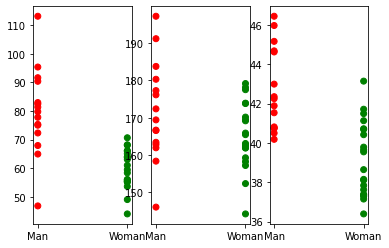

In [2]:
cs = ['red' if i == "Man" else 'green' for i in df['Kind']]

plt.figure()
plt.tight_layout()
plt.subplot(1,3,1)
plt.scatter(df['Kind'], df['Weight'], color=cs)
plt.subplot(1,3,2)
plt.scatter(df['Kind'], df['Height'], color=cs)
plt.subplot(1,3,3)
plt.scatter(df['Kind'], df['Foot'], color=cs)
plt.show()

## 2. Estimate prior probability to be a man $p(man)$ or a woman $p(woman)$ ##
### 2.a pivot table ###

Create a __pivot_table__ named **pivot** that uses 'Kind' column as index for the values of Weight, Height and Foot size. This table should show for each kind (man or woman) and all values: number of elements, mean and standard deviation.

__hint:__ use numpy count_nonzero, mean and std as aggregate functions for the pivot table

In [3]:
## Create pivot_table pivot
pivot = df.pivot_table(index ='Kind',values = ['Weight','Height','Foot'], aggfunc=[np.count_nonzero,'mean','std'])
pivot

count_nonzero                     mean                              std  \
               Foot Height Weight       Foot      Height     Weight      Foot   
Kind                                                                            
Man            15.0   15.0   15.0  42.721625  171.587765  79.786517  2.121678   
Woman          20.0   20.0   20.0  39.209197  165.311617  59.898566  1.875164   

                             
          Height     Weight  
Kind                         
Man    13.188299  15.061624  
Woman   8.933814   6.891315

In [4]:
pivot['count_nonzero'].loc['Man','Foot']


15.0

Computes from this table probability of being a man or a woman. We assume Men/Women ratio in this file is sampled against real proportions.

In [5]:
n_men = int(pivot['count_nonzero'].loc['Man','Foot'])

print("number of men", n_men)

number of men 15


In [6]:
n_women =  int(pivot['count_nonzero'].loc['Woman','Foot'])

print("number of women", n_women)

number of women 20


In [7]:
n_men_women = n_men + n_women
p_man =  n_men/n_men_women
p_woman =  n_women/n_men_women

print("probability of being a man", p_man)
print("probability of being a woman", p_woman)

# for checking
print('sum of the two probability', p_man+p_woman)

probability of being a man 0.42857142857142855
probability of being a woman 0.5714285714285714
sum of the two probability 1.0


### 2.b What are the probability law followed by each features given man or women ###

In this part, we try to estimate the laws followed by: $p(w|man), p(h|man), p(f|man)$, and the same for the woman.
In Bayesian Naive Classifiers, this laws are meant to be Gaussian.

Defines 6 python methods p_w_man, p_h_man,... that corresponsds to probability density function for these 6 laws.

We can use **scipy.stats.norm** and parameters from previous pivot_table


In [8]:
from scipy.stats import norm

## construct p_w_man, p_h_man, p_f_man, p_w_woman, p_h_woman, p_f_woman

p_w_man = norm(pivot['mean'].loc['Man','Weight'],  pivot['std'].loc['Man','Weight'])
p_h_man = norm(pivot['mean'].loc['Man','Height'],  pivot['std'].loc['Man','Height'])
p_f_man = norm(pivot['mean'].loc['Man','Foot'],  pivot['std'].loc['Man','Foot'])

               
p_w_woman = norm(pivot['mean'].loc['Woman','Weight'],  pivot['std'].loc['Woman','Weight'])
p_h_woman = norm(pivot['mean'].loc['Woman','Height'],  pivot['std'].loc['Woman','Height']) 
p_f_woman = norm(pivot['mean'].loc['Woman','Foot'],  pivot['std'].loc['Woman','Foot'])
p_w_man 

In [9]:
norm()

In the following cell, the method __draw_probability_law__ let you verify the methods you just defined. Play with Gender and Parameter to see if your probabily laws seem correct.

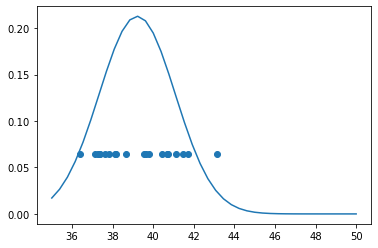

In [10]:
def draw_probability_law(gender, parameter):
    if parameter == 'Weight':
        vals = (20, 150)
        if gender == 'Man':
            law = p_w_man
        else:
            law = p_w_woman
    elif parameter == 'Height':
        vals = (100, 210)
        if gender == 'Man':
            law = p_h_man
        else:
            law = p_h_woman
    else:
        vals = (35, 50)
        if gender == 'Man':
            law = p_f_man
        else:
            law = p_f_woman
        

    paremeters = np.linspace(vals[0], vals[1], 40)
    probas = [law.pdf(w) for w in paremeters]

    values = df[df['Kind'] == gender][parameter]

    cst = [ np.mean(probas) for w in values]

    plt.plot(paremeters, probas)
    plt.scatter(values, cst)
    
## Example
draw_probability_law("Woman", "Foot")

### 2.c Computes likelihood for each feature for each kind ###
 1. Select a tuple (w, h, f) representing your weight, height and foot size.
 2. Then computes for this tuple the likelihood $p(w,h,f|man)$ if you are a man or $p(w,h,f|woman)$
 
In Naive Bayes Classifier, independance of the variables is assumed

In [14]:
m_data= { "w" :80, "h" : 188, "f" : 43  } # I am a man
w_data = { "w": 50, "h" : 172, "f" : 40 } # I am a woman


In [15]:
likelihood_man = p_w_man.pdf(m_data['w'])*p_h_man.pdf(m_data['h'])*p_f_man.pdf(m_data['f'])
likelihood_woman = p_w_woman.pdf(w_data['w'])*p_h_woman.pdf(w_data['h'])*p_f_woman.pdf(w_data['f'])
likelihood_man 

6.885249559649976e-05

### 2.d Computes posterior probabilities $p(man|w,h,f)$ and $p(woman|w,h,f)$ ###

Remember that $$p(man|w,h,f) = \frac{p(man)*likelihood_{man}}{evidence}$$

where $$ likelihood_{man} = p(w,h,f|man) $$
and $$ evidence = p(man)*likelihood_{man} + p(woman)*likelihood_{woman} $$

In [16]:
## Computes posterior probability for m_data

evidence =  p_man*likelihood_man + p_woman*likelihood_woman
posterior_m = (p_man*likelihood_man)/evidence
posterior_w = (p_woman*likelihood_man)/evidence


print(posterior_m, posterior_w)
if posterior_m > posterior_w:
    print(f"I guess your are a man with proba: {posterior_m*100}%")
else:
    print(f"I guess your are a woman with proba: {posterior_w*100}%")

0.27591021542567085 0.3678802872342278
I guess your are a woman with proba: 36.78802872342278%


## Use Scikit-Learn to do the same ##
Idea is here to use a library to do the same classification to avoid all computation by hand.

Use sklearn.naive_bayes.GaussianNB, use df.values to have numpy array.

In [17]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

Y = np.array([1, 1, 1, 2, 2, 2])
Y
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X.shape
Y.shape
clf.fit(X,Y)

GaussianNB()

In [84]:
## Define a classifier clf that is a GaussianNB

## extract from your input dataframe X, and Y that are mandatory to your classifier.
## For X, you need to create in your dataframe an extra column with value 1 for Man and 2 for woman
## Y is built on Weight, Height, Foot columns of the dataframe

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
df['Gender'] = np.array([1 if i=='Man' else 2 for i in df['Kind']])
X =  df[['Weight','Height','Foot']].values 

#df['gender'] = np.where(df['Kind']=='Man', 1,2)
Y = df['Gender'].values
clf.fit(X,Y)
Y

array([1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1])

Then we test that we obtain the same results for class definitions as the ones calculated by hand
(compare with result obtained in 2.a)

In [77]:
print(clf.class_prior_) 
print(clf.theta_)
print(np.sqrt(clf.sigma_))

[0.42857143 0.57142857]
[[ 79.78651701 171.58776499  42.72162534]
 [ 59.89856644 165.31161681  39.20919681]]
[[14.55091101 12.74110727  2.049736  ]
 [ 6.71682304  8.7076052   1.82768408]]


Using your classifier **clf** compute again gender predicted by our classifier on extra data

In [78]:
m_data = { "w" :80, "h" : 188, "f" : 43  } # I am a man
w_data = { "w": 50, "h" : 172, "f" : 40 } # I am a woman

#predict = clf.predict([[50,172,40],[ 50, 172, 40]])
predict = clf.predict([[m_data['w'],m_data['h'], m_data['f']],[w_data['w'],w_data['h'],w_data['f']]])
predict
a = [[m_data['w'],m_data['h'], m_data['f']],[w_data['w'],w_data['h'],w_data['f']]]
b = [[m_data['w'],m_data['h'], m_data['f']]]
b

[[80, 188, 43]]

Then use classifier on our X dataset again and see how well it performs by drawing a confustion matrix


In [79]:

## Computes prediction Y_predicted using classifier clf
Y_predicted = clf.predict(X)

#print Y and the one predicted for direct comparaison.
print(Y)
print(Y_predicted)


[1 2 2 2 2 2 1 1 1 1 2 1 1 2 1 1 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 1 1 1]
[1 2 2 1 2 2 1 1 1 1 2 1 1 2 1 1 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 1 1 1 1]


In [66]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




Confusion matrix, without normalization


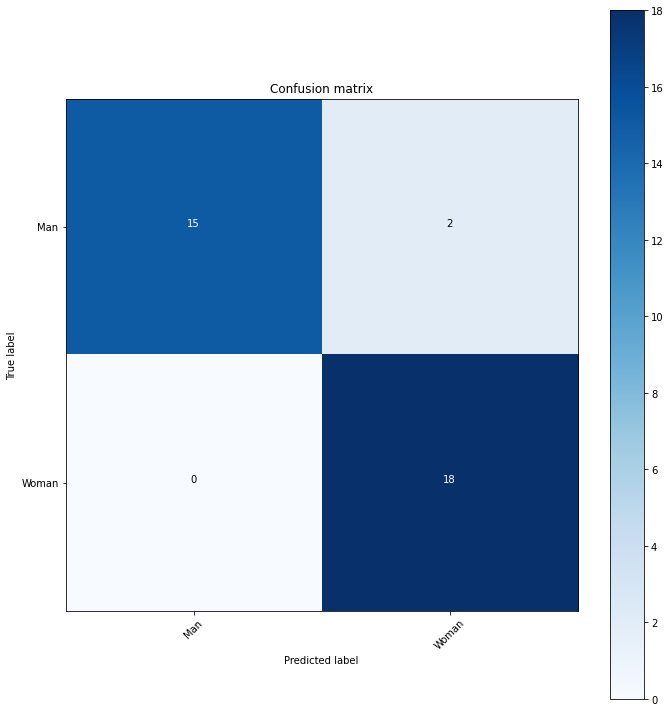

In [86]:
##Your Code Here
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

class_names = ['Man', 'Woman' ]
confusion = confusion_matrix(Y_predicted, Y)

class_names = ['Man', 'Woman' ]
plot_confusion_matrix(confusion, classes=class_names)